## One vs One classifier

Building a multiclass classifier using binary classifiers

In [1]:
# Import util.ipynb for helper functions
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
            for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [2]:
# Imports

from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils.ipynb


In [3]:
fig = plt.figure(figsize=(8,8));

np.random.seed(4)

# Getting only linearly separable dataset
separable = False
while not separable:
    samples = make_classification(n_samples=450, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3)
    red = samples[0][samples[1] == 0]
    blue = samples[0][samples[1] == 1]
    green = samples[0][samples[1] == 2]
    separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() 
                  or green[:, k].min() > blue[:, k].max() or green[:, k].min() > red[:, k].max() 
                  or blue[:, k].min() > green[:, k].max() or red[:, k].min() > green[:, k].max() for k in range(2)])

X, y = samples

y = y.reshape((-1, 1))

# Absorbing weight b of the hyperplane
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

<Figure size 576x576 with 0 Axes>

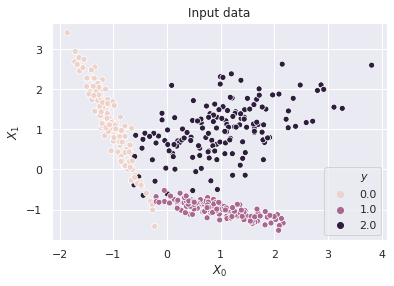

In [4]:
plot_2D_input_datapoints(X[:, :2], y)

In [5]:
# Train-Val-Test split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, shuffle=True, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.125)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (315, 3)
Validation dataset:  (45, 3)
Test dataset:  (90, 3)


In [8]:
temp = []
temp.append(X[0])
temp.append(X[1])
print(np.asarray(temp).shape)

(2, 3)


In [10]:
def train_one_vs_one(X_train, Y_train, base_weights, num_epochs=1000, learning_rate=0.1):

    n_samples, n_features = np.shape(X_train)
    _, n_outputs = np.shape(y)

    classes = np.unique(Y_train)
    

    # Training using Batch GD
    history_weights = []
    
    
    for k1 in classes:
    
        weights_k_classes = []
        for k2 in classes:
            # one-vs-one binary classifier

            if k1>=k2:
                weights_k_classes.append(base_weights*0)
                continue
            
            binary_y_train  = np.where(Y_train == k1, 1, 0)
            binary_y_train += np.where(Y_train == k2, -1, 0)
            
            byt = []; Xt = []
            for it in range(n_samples):
                if binary_y_train[it] != 0:
                    byt.append(binary_y_train[it]+1>>1)
                    Xt.append(X_train[it])
            
            binary_y_train = np.asarray(byt)
            X_train1 = np.asarray(Xt)
            
            weights = base_weights

            for epoch in range(1, num_epochs+1):
    
                # Computing weighted inputs and predicting output
                w_transpose_x = np.dot(X_train1, weights)
                y_pred = sigmoid(w_transpose_x)

                # Calculating gradient and updating weights
                gradient = 1 * np.dot(X_train1.T, (binary_y_train - y_pred))
                weights += (learning_rate/n_samples) * gradient
                weights = np.round(weights, decimals=7)

                epoch += 1

            weights_k_classes.append(weights)
        history_weights.append(weights_k_classes)

    print("Training complete")
    return history_weights

In [11]:
# Let's initialize our weights using uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights


weights = weight_init_uniform_dist(X_train, Y_train)

In [31]:
trained_weights = train_one_vs_one(X_train, Y_train, weights, num_epochs=1000, learning_rate=0.1)
#print(len(trained_weights),len(trained_weights[0]),len(trained_weights[0][0]))
#print(trained_weights[1][2])

Training complete


In [37]:
# Compute the accuracy of training data and validation data
def predict_one_vs_one(trained_weights, X_input, Y_input):
  
    num_classes = len(np.unique(Y_input))
    scores = np.zeros((num_classes , (X_input.shape)[0]))

    for k1 in range(num_classes):
        for k2 in range(num_classes):
    
            if k1>=k2:
                continue
            
            binary_y_input = np.where(Y_input == k1, 1, 0)

            w_transpose_x = np.dot(X_input, trained_weights[k1][k2])
            y_pred = sigmoid(w_transpose_x)
            y_pred = y_pred.reshape((-1,))
            y_pred=y_pred*2-1
            
            scores[k1, :] += np.sign(y_pred)
            scores[k2, :] -= np.sign(y_pred)
    
    pred_X = np.argmax(scores, axis=0)
    #print(scores)
    return pred_X
#print(pred_val_one_vs_one)

In [38]:
pred_train_one_vs_one = predict_one_vs_one(trained_weights, X_train, Y_train)
pred_val_one_vs_one = predict_one_vs_one(trained_weights, X_val, Y_val)
pred_test_one_vs_one = predict_one_vs_one(trained_weights, X_test, Y_test)

pred_train_one_vs_one = pred_train_one_vs_one.reshape((-1, 1))
pred_val_one_vs_one = pred_val_one_vs_one.reshape((-1, 1))
pred_test_one_vs_one = pred_test_one_vs_one.reshape((-1, 1))

print('Training dataset accuracy: %f' % (np.mean(Y_train == pred_train_one_vs_one)))
print('Validation dataset accuracy: %f' % (np.mean(Y_val == pred_val_one_vs_one)))
print('Test datast accuracy: %f' % (np.mean(Y_test == pred_test_one_vs_one)))

Training dataset accuracy: 0.952381
Validation dataset accuracy: 0.955556
Test datast accuracy: 0.977778


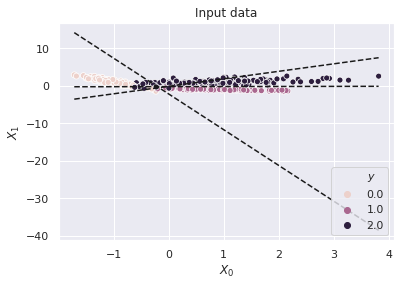

In [42]:
plot_2D_input_datapoints(X_train[:, :2], Y_train)
plt.xlabel("$X_0$"); plt.ylabel("$X_1$")

num_classes = len(np.unique(y))

for k1 in range(num_classes):
    for k2 in range(num_classes):
        if k1>=k2:
            continue
        weight = trained_weights[k1][k2]
        j = np.array([X_train[:, 0].min(), X_train[:, 0].max()])
        k = -(j * weight[0] + weight[2]) / weight[1]
        plt.plot(j, k, color='k', linestyle="--")
    